In [7]:
import os
import numpy as np
import leafmap
import rasterio as rio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Set a workdir and go to it
workdir = '/Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_visualization'
print('Going to work dir: ', workdir)
os.chdir(workdir)

Going to work dir:  /Users/cabrera/Documents/jpl_projects/opera_dist/dist-s1-research/oliver/rtc_visualization


In [3]:
# Load the CSV file into a DataFrame using Pandas
rtc_table = pd.read_csv('./rtc_s1_table.csv')

# Assuming your CSV has latitude and longitude columns, you can create a 'geometry' column using those coordinates.
# First, create a 'geometry' column using the latitude and longitude.
# rtc_table['geometry'] = gpd.points_from_xy(rtc_table['longitude'], rtc_table['latitude'])

# convert the DataFrame to a GeoDataFrame.
# rtc_gdf = gpd.GeoDataFrame(rtc_table, geometry='geometry')
# rtc_gdf.crs = 'EPSG:4326'

In [4]:
filtered_df = rtc_table[rtc_table['jpl_burst_id'].str.startswith('T036-076225-IW1')]
rtc_s1_vv_url_list = filtered_df['rtc_s1_vv_url'].tolist()
filtered_count = len(filtered_df)
print('Image count =', filtered_count)
print('Sample link =', rtc_s1_vv_url_list[0])
filtered_df

Image count = 96
Sample link = https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/RTC_S1/OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T036-076225-IW1_20201006T042403Z_20240426T220152Z_S1B_30_v1.0_VV.tif


,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url
0,OPERA_L2_RTC-S1_T036-076225-IW1_20201006T04240...,S1B_IW_SLC__1SDV_20201006T042402_20201006T0424...,T036-076225-IW1,25,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
45,OPERA_L2_RTC-S1_T036-076225-IW1_20201012T04244...,S1A_IW_SLC__1SDV_20201012T042442_20201012T0425...,T036-076225-IW1,30,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
74,OPERA_L2_RTC-S1_T036-076225-IW1_20201018T04240...,S1B_IW_SLC__1SDV_20201018T042402_20201018T0424...,T036-076225-IW1,25,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
80,OPERA_L2_RTC-S1_T036-076225-IW1_20201024T04244...,S1A_IW_SLC__1SDV_20201024T042442_20201024T0425...,T036-076225-IW1,30,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
117,OPERA_L2_RTC-S1_T036-076225-IW1_20201030T04240...,S1B_IW_SLC__1SDV_20201030T042402_20201030T0424...,T036-076225-IW1,25,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
...,...,...,...,...,...,...,...
2532,OPERA_L2_RTC-S1_T036-076225-IW1_20220815T04245...,S1A_IW_SLC__1SDV_20220815T042451_20220815T0425...,T036-076225-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
2563,OPERA_L2_RTC-S1_T036-076225-IW1_20220827T04245...,S1A_IW_SLC__1SDV_20220827T042451_20220827T0425...,T036-076225-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
2611,OPERA_L2_RTC-S1_T036-076225-IW1_20220908T04245...,S1A_IW_SLC__1SDV_20220908T042452_20220908T0425...,T036-076225-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...
2630,OPERA_L2_RTC-S1_T036-076225-IW1_20220920T04245...,S1A_IW_SLC__1SDV_20220920T042451_20220920T0425...,T036-076225-IW1,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...


In [5]:
# Read a group of images and display them using leafmap
# Create a LeafMap instance
m = leafmap.Map()

# Add the images to the map
for rtc_path in rtc_s1_vv_url_list[0:5]:
    # Add the image to the map
    m.add_raster(rtc_path, colormap='gray', vmin=0, vmax=0.5)

# Display the map
m


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

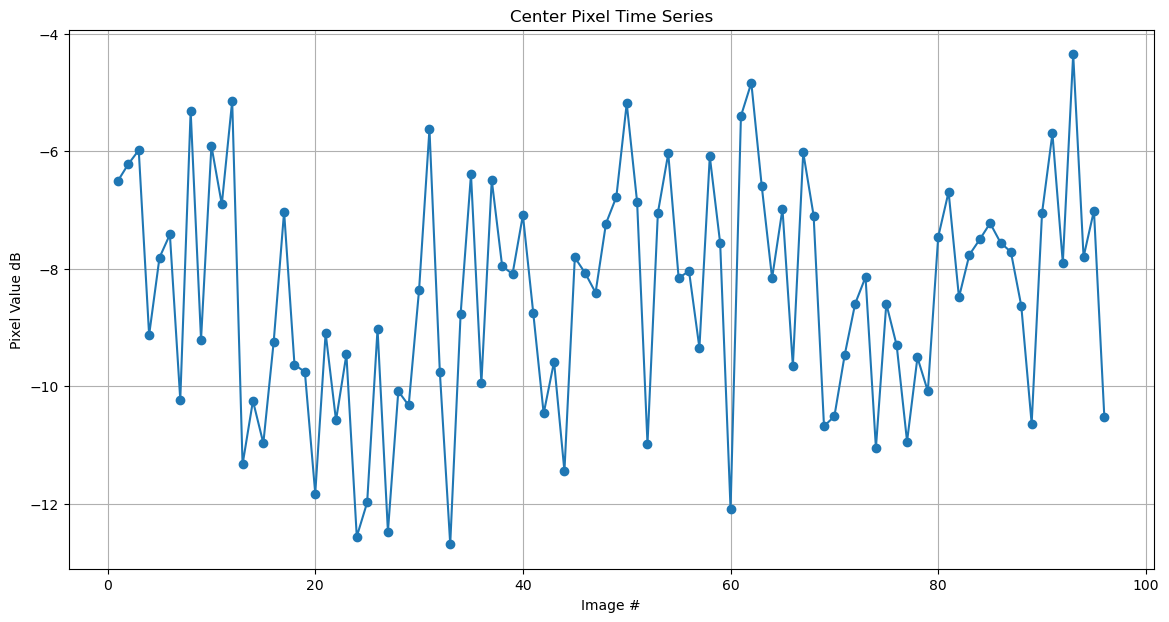

In [12]:
def load_image(image_path):
    with rio.open(image_path) as src:
        return src.read(1)

def extract_center_pixel(image):
    height, width = image.shape
    center_row = height // 2
    center_col = width // 2
    return image[center_row, center_col]

def plot_center_pixel_time_series(image_paths):
    time_series = []

    for image_path in image_paths:
        image = load_image(image_path)
        center_pixel_value = extract_center_pixel(image)
        center_pixel_value = 10 * np.log10(center_pixel_value)
        time_series.append(center_pixel_value)

    plt.figure(figsize=(14, 7))
    plt.plot(range(1, len(time_series) + 1), time_series, marker='o')
    plt.title('Center Pixel Time Series')
    plt.xlabel('Image #')
    plt.ylabel('Pixel Value dB')
    plt.grid(True)
    plt.show()

# List of image paths
image_paths = [rtc_s1_vv_url_list[1], rtc_s1_vv_url_list[2], rtc_s1_vv_url_list[3], rtc_s1_vv_url_list[4]]
#rtc_s1_vv_url_list

# Plot center pixel time series
plot_center_pixel_time_series(rtc_s1_vv_url_list)

In [6]:
# leafmap.image_comparison(
#     rtc_s1_vv_url_list[0],
#     rtc_s1_vv_url_list[5],
#     label1="Satellite Image",
#     label2="Image Segmentation",
#     starting_position=50,
#     out_html="image_comparison.html",
# )